In [42]:
# Importing the libraries
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision

In [10]:
# Checking device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [11]:
# Load data
train_dataset = datasets.MNIST(root = './Data', train = True, transform = transforms.ToTensor(), download = True)

test_dataset = datasets.MNIST(root = './Data', train = False, transform = transforms.ToTensor())

In [12]:
# Hyper parameters

batch_size = 100
sequence_length = 28
num_layers = 2
learning_rate = 0.001
input_size =  28
hidden_size = 128
n_classes = 10
num_epochs  = 10

In [13]:
# Loading dataset using data loader
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True )
test_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = False)

In [14]:
# Size of the samples and labels
examples = iter(train_loader)
samples, labels = next(examples)
print(samples.shape, labels.shape) # samples shape is 100, 1, 28, 28 which is 100 samples, 1 channel, 28 * 28 pixels
# labels shape is 100, which is 100 labels

torch.Size([100, 1, 28, 28]) torch.Size([100])


In [18]:
# Implementing the Neural Network

class RNN(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, n_classes):
        super(RNN,self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, n_classes)
    

    def forward(self, x):
        # Initial hidden state 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) # 2, 100, 128
        out, _ = self.rnn(x, h0)
        # out : batch_size, seq_length, hidden_size
        # Output = [N, 28, 128]
        out = out[:, -1, :]
        out = self.fc(out)
        return out


model = RNN(input_size, hidden_size, num_layers, n_classes).to(device) # 28, 128, 2, 10


# Loss and Optimiser
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)


# Training loop
n_totalsteps = len(train_loader)

for epoch in range(num_epochs):

    for i, (images, labels) in enumerate(train_loader):
        #  Reshape the images because the model expects a 1D tensor as input
        images = images.reshape(-1,sequence_length, input_size).to(device) # Batch size, sequence length, input size = 100, 28, 28
        labels = labels.to(device)

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_totalsteps}], Loss: {loss.item():.4f}')


# Test

with torch.no_grad():
    n_correct = 0
    n_samples = 0

    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size ).to(device)
        lables = labels.to(device)
        output = model(images)

        _ , predictions = torch.max(output,1)
        n_samples = labels.shape[0]

        n_correct = (predictions == labels).sum().item()
    
    acc = (n_correct / n_samples) * 100

    print(f'Accuracy of the model : {acc}')


Epoch [1/10], Step [100/600], Loss: 0.9453
Epoch [1/10], Step [200/600], Loss: 0.7098
Epoch [1/10], Step [300/600], Loss: 0.5149
Epoch [1/10], Step [400/600], Loss: 0.3086
Epoch [1/10], Step [500/600], Loss: 0.4703
Epoch [1/10], Step [600/600], Loss: 0.1764
Epoch [2/10], Step [100/600], Loss: 0.1954
Epoch [2/10], Step [200/600], Loss: 0.3411
Epoch [2/10], Step [300/600], Loss: 0.2525
Epoch [2/10], Step [400/600], Loss: 0.3689
Epoch [2/10], Step [500/600], Loss: 0.2466
Epoch [2/10], Step [600/600], Loss: 0.1027
Epoch [3/10], Step [100/600], Loss: 0.1523
Epoch [3/10], Step [200/600], Loss: 0.1909
Epoch [3/10], Step [300/600], Loss: 0.1529
Epoch [3/10], Step [400/600], Loss: 0.1831
Epoch [3/10], Step [500/600], Loss: 0.1077
Epoch [3/10], Step [600/600], Loss: 0.0823
Epoch [4/10], Step [100/600], Loss: 0.2108
Epoch [4/10], Step [200/600], Loss: 0.1261
Epoch [4/10], Step [300/600], Loss: 0.2030
Epoch [4/10], Step [400/600], Loss: 0.2461
Epoch [4/10], Step [500/600], Loss: 0.1084
Epoch [4/10

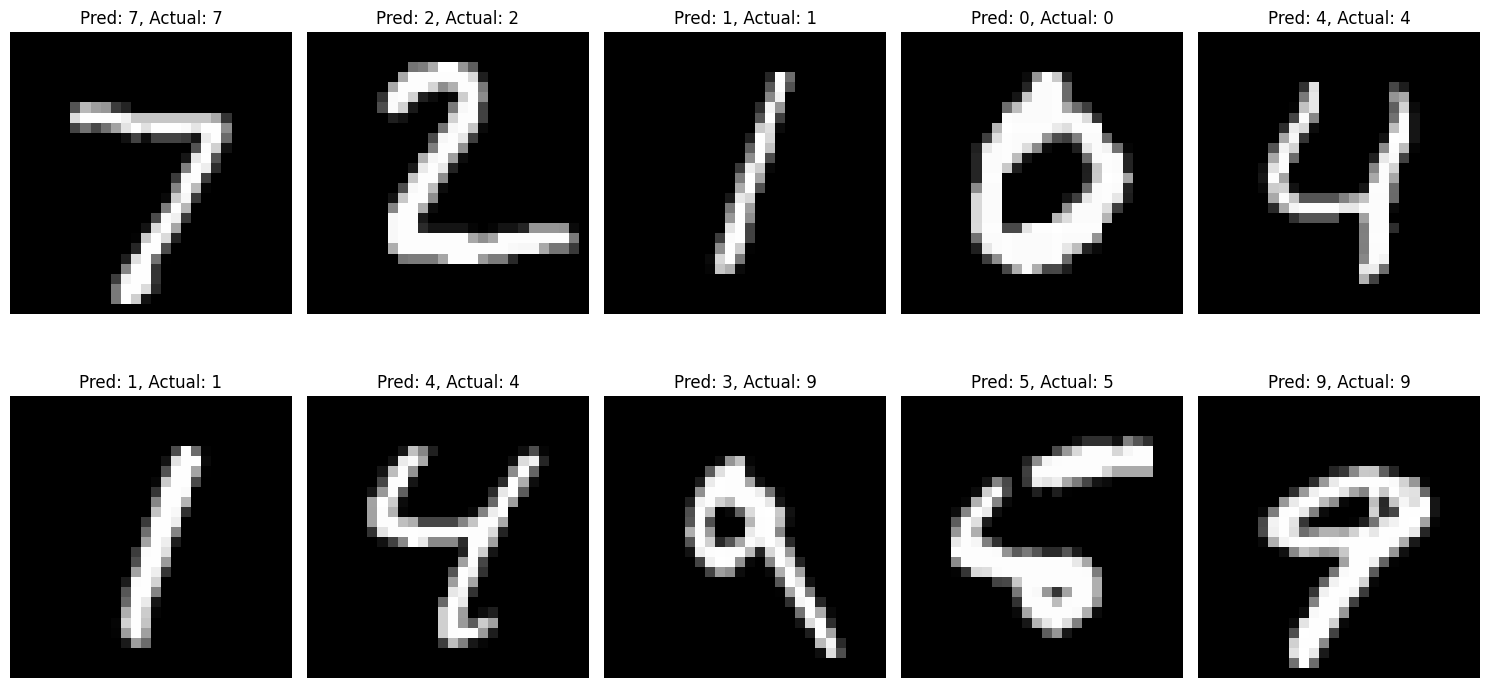

In [45]:
def plot_img_with_labels(images, predicted, actual, nrow=5):
    fig, axes = plt.subplots(nrows=(len(images) + nrow - 1) // nrow, ncols=nrow, figsize=(15, 8))
    axes = axes.flatten()
    
    for i, (img, pred, act) in enumerate(zip(images, predicted, actual)):
        grid_image = torchvision.utils.make_grid(img.unsqueeze(0), nrow=1)
        np_image = grid_image.cpu().numpy().transpose((1, 2, 0))
        axes[i].imshow(np_image, cmap='gray')
        axes[i].set_title(f'Pred: {pred}, Actual: {act}')
        axes[i].axis('off')

    for ax in axes[len(images):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

images_list = []
predicted_list = []
actual_list = []

for ele in range(10):
    images, labels = test_dataset[ele]
    images = images.reshape(-1, sequence_length, input_size).to(device)
    output = model(images)
    _, predictions = torch.max(output, 1)
    
    images_list.append(images.cpu())
    predicted_list.append(predictions.item())
    actual_list.append(labels)

plot_img_with_labels(images_list, predicted_list, actual_list)